In [1]:
import cv2
import os
import numpy as np


In [2]:
def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


In [3]:
import math

def rotate_point(x, y, angle, cx, cy):
    """Rotate a point around a center point."""
    angle = math.radians(angle)
    x_new = (math.cos(angle) * (x - cx)) - (math.sin(angle) * (y - cy)) + cx
    y_new = (math.sin(angle) * (x - cx)) + (math.cos(angle) * (y - cy)) + cy
    return x_new, y_new

def adjust_annotations_for_rotation(annotations, image_width, image_height, angle):
    new_annotations = []
    cx, cy = image_width / 2, image_height / 2  # Centre de l'image

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        # Calculer les coins de la boîte englobante
        x1, y1 = x_center - width / 2, y_center - height / 2
        x2, y2 = x_center + width / 2, y_center + height / 2

        # Rotate corners
        x1_new, y1_new = rotate_point(x1, y1, angle, cx, cy)
        x2_new, y2_new = rotate_point(x2, y2, angle, cx, cy)

        # Calculate new bounding box (axis-aligned)
        x_center_new = (x1_new + x2_new) / 2
        y_center_new = (y1_new + y2_new) / 2
        width_new = abs(x2_new - x1_new)
        height_new = abs(y2_new - y1_new)

        # Normaliser les coordonnées
        x_center_new /= image_width
        y_center_new /= image_height
        width_new /= image_width
        height_new /= image_height

        new_annotations.append(f"{class_id} {x_center_new} {y_center_new} {width_new} {height_new}\n")

    return new_annotations


In [4]:
def flip_image(image, flipCode):
    return cv2.flip(image, flipCode)


In [5]:
def flip_annotations_horizontally(annotations, image_width, flipCode):
    new_annotations = []
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())

        if flipCode == 1:  # Flip horizontal
            x_center = 1 - x_center
        elif flipCode == 0:  # Flip vertical - si nécessaire
            # Ajoutez ici le code pour gérer le flip vertical
            pass

        new_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}\n")
    return new_annotations


In [6]:
def adjust_brightness(image, value):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


In [7]:
# Fonction pour lire les annotations
def read_annotation(file_path):
    with open(file_path, 'r') as file:
        annotations = file.readlines()
    return annotations


In [8]:
# Fonction pour écrire les nouvelles annotations
def write_annotation(new_file_path, annotations):
    with open(new_file_path, 'w') as file:
        for annotation in annotations:
            file.write(annotation)


In [9]:
import random

def apply_random_transformation(image, annotations):
    transformation_choice = random.choice(['rotate', 'flip', 'brightness'])
    if transformation_choice == 'rotate':
        angle = random.choice([0, 90, 180, 270])
        transformed_image = rotate_image(image, angle)
        transformed_annotations = adjust_annotations_for_rotation(annotations, image.shape[1], image.shape[0], angle)
    elif transformation_choice == 'flip':
        flipCode = random.choice([-1, 0, 1])  # -1, 0, 1 pour différents types de flip
        transformed_image = flip_image(image, flipCode)
        transformed_annotations = flip_annotations_horizontally(annotations, image.shape[1], flipCode)
    else:  # 'brightness'
        brightness_value = random.randint(-50, 50)
        transformed_image = adjust_brightness(image, brightness_value)
        transformed_annotations = annotations  # Aucun changement pour les annotations

    return transformed_image, transformed_annotations


In [10]:
def process_images_annotations(images_directory, annotations_directory, new_images_directory, new_annotations_directory, num_transformations):
    new_images_count = 0
    for filename in os.listdir(images_directory):
        if filename.endswith(".jpg"):
            file_path = os.path.join(images_directory, filename)
            annotation_path = os.path.join(annotations_directory, filename.replace('.jpg', '.txt'))

            for i in range(num_transformations):
                image = cv2.imread(file_path)
                annotations = read_annotation(annotation_path)

                transformed_image, transformed_annotations = apply_random_transformation(image, annotations)
                new_image_file = os.path.join(new_images_directory, f"transformed_image_{new_images_count}.jpg")
                new_annotation_file = os.path.join(new_annotations_directory, f"transformed_annotation_{new_images_count}.txt")

                cv2.imwrite(new_image_file, transformed_image)
                write_annotation(new_annotation_file, transformed_annotations)

                new_images_count += 1


In [12]:
# Les chemins des dossiers
base_directory = "raw_data/EpicureAi.v3-resize-512x512-reoriented.yolov8"
train_images_directory = os.path.join(base_directory, "train/images")
train_annotations_directory = os.path.join(base_directory, "train/labels")
validation_images_directory = os.path.join(base_directory, "validation/images")
validation_annotations_directory = os.path.join(base_directory, "validation/labels")
new_dataset_directory = "raw_data/new_dataset"
new_images_directory = os.path.join(new_dataset_directory, "images")
new_annotations_directory = os.path.join(new_dataset_directory, "labels")


In [13]:
# Traitement des images d'entraînement et de validation avec le nombre approprié de transformations
process_images_annotations(train_images_directory, train_annotations_directory, new_images_directory, new_annotations_directory, 6)  # 6 transformations par image d'entraînement
process_images_annotations(validation_images_directory, validation_annotations_directory, new_images_directory, new_annotations_directory, 17)  # 17 transformations par image de validation


In [14]:
'''# Créer les nouveaux dossiers s'ils n'existent pas
os.makedirs(new_images_directory, exist_ok=True)
os.makedirs(new_annotations_directory, exist_ok=True)

# Process train directory
process_images_annotations(train_images_directory, train_annotations_directory,
                           new_images_directory, new_annotations_directory,
                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)

# Process validation directory
process_images_annotations(validation_images_directory, validation_annotations_directory,
                           new_images_directory, new_annotations_directory,
                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)'''


"# Créer les nouveaux dossiers s'ils n'existent pas\nos.makedirs(new_images_directory, exist_ok=True)\nos.makedirs(new_annotations_directory, exist_ok=True)\n\n# Process train directory\nprocess_images_annotations(train_images_directory, train_annotations_directory,\n                           new_images_directory, new_annotations_directory,\n                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)\n\n# Process validation directory\nprocess_images_annotations(validation_images_directory, validation_annotations_directory,\n                           new_images_directory, new_annotations_directory,\n                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)"

In [15]:
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Compter les fichiers dans les dossiers
num_images = count_files(new_images_directory)
num_labels = count_files(new_annotations_directory)

print("Nombre d'images:", num_images)
print("Nombre de labels:", num_labels)


Nombre d'images: 750
Nombre de labels: 750


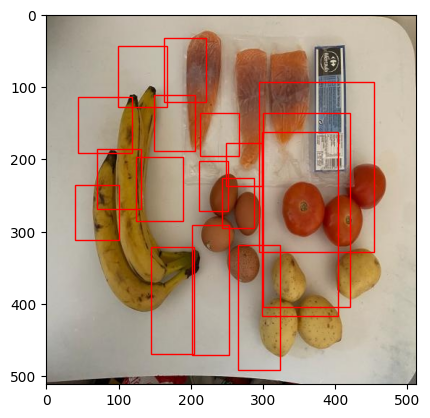

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_annotations(image_file, annotation_file):
    # Lire l'image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB

    # Lire les annotations
    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    # Afficher l'image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Dessiner les boîtes englobantes
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x_center, y_center, width, height = x_center * image.shape[1], y_center * image.shape[0], width * image.shape[1], height * image.shape[0]
        rect = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Test avec une image et son label
sample_image_file = os.path.join(new_images_directory, "transformed_image_200.jpg")
sample_annotation_file = os.path.join(new_annotations_directory, "transformed_annotation_200.txt")

show_image_with_annotations(sample_image_file, sample_annotation_file)
